In [8]:
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline
%autosave 15

Autosaving every 15 seconds


In [4]:
with open('benchmark.log', 'r') as f:
    lines = f.readlines()

In [9]:
def decay(log):
    for k, v in log.items():
        if v == dict():
            yield tuple(k.split(': ', 1))
        else:
            yield k, dict(decay(v))

def parse_log(lines):
    data = dict()
    stack = [data]
    
    for line in lines:
        tokens = line.strip().split('+ ')
        depth = 1
        while len(tokens) > 0 and tokens[0] == '':
            depth += 1
            tokens = tokens[1:]
        s = '+ '.join(tokens)
        
        stack = stack[:depth]
        if len(stack) < depth:
            raise RuntimeError("Bad indentation")
        else:
            d = dict()
            stack[-1][s] = d    
            stack.append(d)
    
    return dict(decay(data))

log = parse_log(lines)
print(log)

{'Full Graph Test': {'Graph size: 2': {'Solver: ReducingToSATSolver': {'Correct': 'true', 'Time elapsed': '38.604557 ms (38604557 ns)'}, 'Solver: BacktrackingSolver': {'Correct': 'true', 'Time elapsed': '0.029755 ms (29755 ns)'}}, 'Graph size: 4': {'Solver: ReducingToSATSolver': {'Correct': 'true', 'Time elapsed': '1.542331 ms (1542331 ns)'}, 'Solver: BacktrackingSolver': {'Correct': 'true', 'Time elapsed': '0.016911 ms (16911 ns)'}}, 'Graph size: 6': {'Solver: ReducingToSATSolver': {'Correct': 'true', 'Time elapsed': '1.396055 ms (1396055 ns)'}, 'Solver: BacktrackingSolver': {'Correct': 'true', 'Time elapsed': '0.027067 ms (27067 ns)'}}, 'Graph size: 8': {'Solver: ReducingToSATSolver': {'Correct': 'true', 'Time elapsed': '2.028631 ms (2028631 ns)'}, 'Solver: BacktrackingSolver': {'Correct': 'true', 'Time elapsed': '0.038973 ms (38973 ns)'}}, 'Graph size: 10': {'Solver: ReducingToSATSolver': {'Correct': 'true', 'Time elapsed': '2.093924 ms (2093924 ns)'}, 'Solver: BacktrackingSolver': 

In [13]:
def parse_test(test_log, test_name_parser):
    r = re.compile(r'^.*\((\d+) ns\)$')
    solvers = dict()
    
    tests = []
    results = []
    
    for name, case in test_log.items():
        tests.append(test_name_parser(name))
        for solver, data in case.items():
            if solver not in solvers:
                idx = len(solvers)
                solvers[solver] = idx
                results.append([])
            idx = solvers[solver]
            
            time_regex = r.match(data["Time elapsed"])
            time = None if time_regex is None else int(time_regex.groups()[0])
            results[idx].append(time)
    
    solvers_list = [None] * len(solvers)
    for k, v in solvers.items():
        solvers_list[v] = k
    
    return solvers_list, tests, results

tests = {k: parse_test(v, lambda s: s[len("Graph size: "):]) for k, v in log.items()}
print(tests)

{'Full Graph Test': (['Solver: ReducingToSATSolver', 'Solver: BacktrackingSolver'], ['2', '4', '6', '8', '10', '20', '30', '40', '50', '100', '150', '200', '250', '300'], [[38604557, 1542331, 1396055, 2028631, 2093924, 7467296, 18890552, 37808309, 44137236, 176061540, 583222610, 1259265726, 2595449976, 4277614795], [29755, 16911, 27067, 38973, 65785, 188610, 238351, 387013, 518850, 805937, 774870, 1472629, 2150739, 3104889]]), 'Cyclic Graph Test': (['Solver: ReducingToSATSolver', 'Solver: BacktrackingSolver'], ['2', '4', '6', '8', '10', '20', '30', '40', '50', '100', '150', '200', '250', '300'], [[369075, 351340, 623583, 974276, 1304578, 8867756, 34804917, 57757699, 38474181, 436221257, 1818714879, 4570309500, 9619140974, 18851691580], [24905, 21178, 48003, 29899, 35432, 84165, 102298, 89468, 804921, 231177, 229358, 136067, 152466, 180136]]), 'Grid Graph Test': (['Solver: ReducingToSATSolver', 'Solver: BacktrackingSolver'], ['1 x 1', '1 x 3', '1 x 5', '1 x 7', '1 x 9', '1 x 11', '1 x 1

In [16]:
def prepare_test(keys, values):
    d = dict()
    for key, value in zip(keys, values):
        k = 1
        for tok in key.split(' x '):
            k *= int(tok)
            
        d.setdefault(k, [])
        d[k].append(value)
    
    agg_keys = sorted(list(d.keys()))
    agg_vals = [np.mean(d[k]) for k in agg_keys]
    return np.array(agg_keys), np.array(agg_vals)

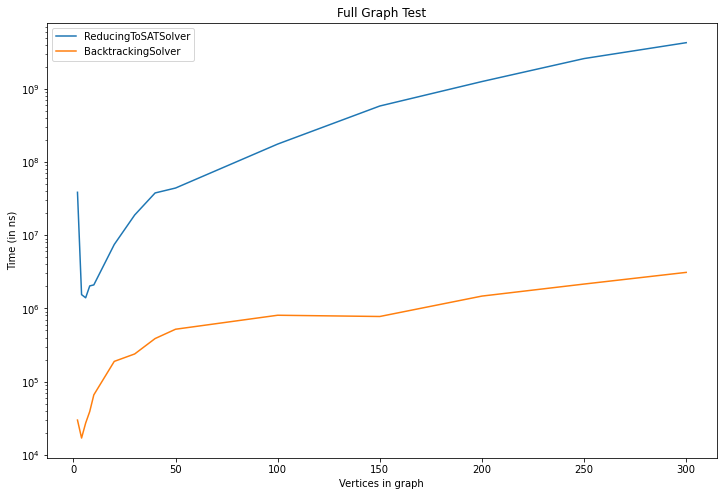

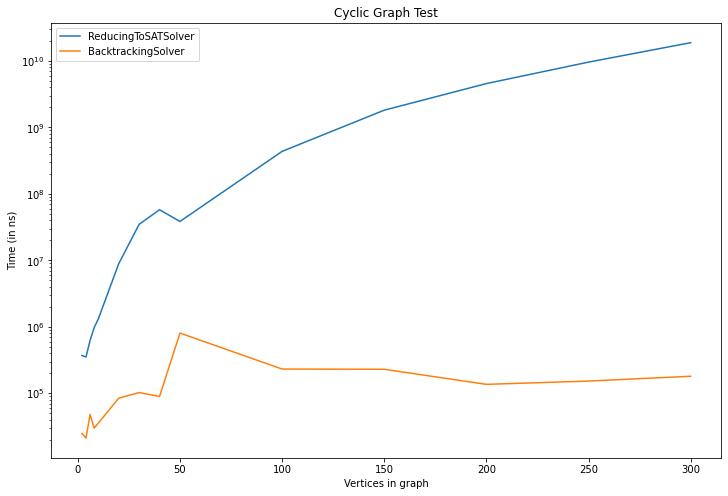

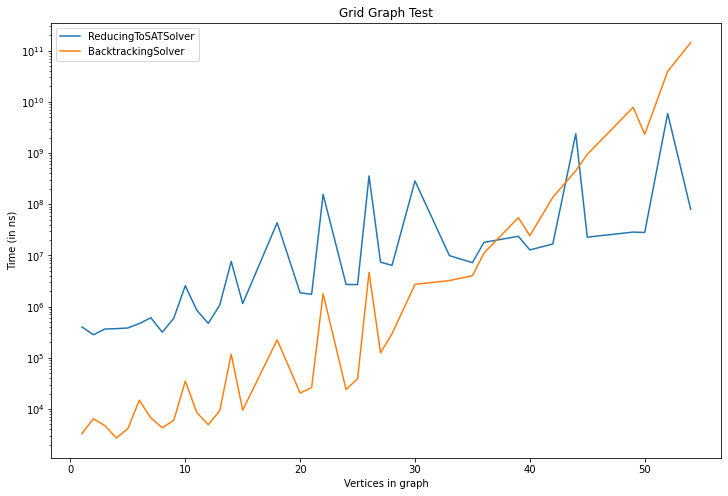

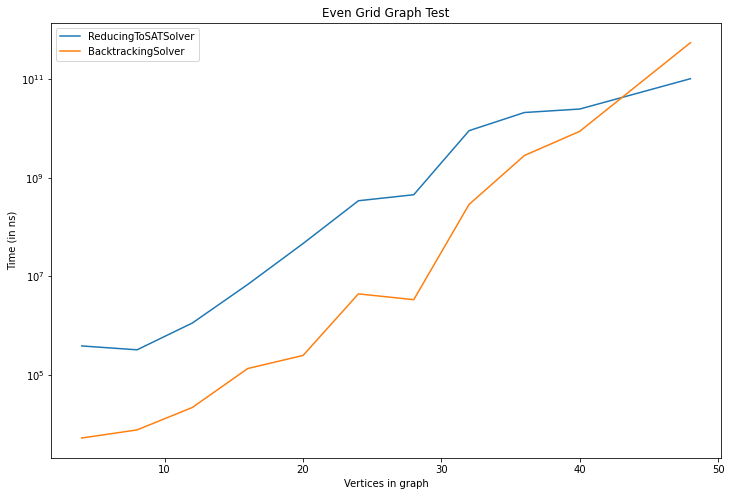

In [21]:
for name, (solvers, keys, results) in tests.items():
    plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.xlabel('Vertices in graph')
    plt.ylabel('Time (in ns)')
    plt.yscale('log')
    
    for solver, values in zip(solvers, results):
        plt.plot(*prepare_test(keys, values), label=solver.split(': ', 1)[1])
    
    plt.legend()
    plt.savefig(''.join(name.split()) + '.png')
    plt.show()